In [75]:
from google.colab import drive, files

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # matplotlib.pyplot plots data
%matplotlib inline 
import seaborn as sns
sns.set(color_codes=True)

from zipfile import ZipFile
import os, math, sys, cv2
from matplotlib.patches import Rectangle

!pip install -q pydicom
import pydicom as dcm
from tqdm import tqdm_notebook
!pip install -U albumentations
import albumentations as alb

!pip install keras==2.2.5
%tensorflow_version 1.x

!pip install h5py==2.10.0

Requirement already up-to-date: albumentations in /usr/local/lib/python3.7/dist-packages (1.0.0)
  Using cached https://files.pythonhosted.org/packages/f8/ba/2d058dcf1b85b9c212cc58264c98a4a7dd92c989b798823cc5690d062bb2/Keras-2.2.5-py2.py3-none-any.whl
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [2]:
!pip install --upgrade --force-reinstall --no-deps kaggle
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c rsna-pneumonia-detection-challenge

     |████████████████████████████████| 61kB 2.9MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=ec6aef138c4c4009f0f271752a1bd6ef49f441575da5e45ae25ea220641e7390
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


Saving kaggle.json to kaggle.json
100% 3.64G/3.66G [01:35<00:00, 20.1MB/s]
100% 3.66G/3.66G [01:35<00:00, 41.2MB/s]


In [3]:
file_name = 'rsna-pneumonia-detection-challenge.zip'
datafile = ZipFile(file_name, 'r')
datafile.extractall()

In [4]:
data_folder = '/content/'

train_labels = pd.read_csv(data_folder + 'stage_2_train_labels.csv')
class_info = pd.read_csv(data_folder +'stage_2_detailed_class_info.csv')

print(f'Train Labels has {train_labels.shape[0]} rows and {train_labels.shape[1]} columns')
print(f'Class info has {class_info.shape[0]} rows and {class_info.shape[1]} columns')
print('Train Labels # of patientID duplicates: {}'.format(len(train_labels) - (train_labels['patientId'].nunique())))
print('Class Info # of patientID duplicates: {}'.format(len(class_info) - (class_info['patientId'].nunique())))

Train Labels has 30227 rows and 6 columns
Class info has 30227 rows and 2 columns
Train Labels # of patientID duplicates: 3543
Class Info # of patientID duplicates: 3543


Printing the first few rows of "Train Labels" and "Class Info"

In [5]:
print('Train labels :\n'); display(train_labels.head(10))
print('\nClass info :\n'); display(class_info.head(10))

Train labels :



patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1
5  00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0       1
6  00569f44-917d-4c86-a842-81832af98c30    NaN    NaN    NaN     NaN       0
7  006cec2e-6ce2-4549-bffa-eadfcd1e9970    NaN    NaN    NaN     NaN       0
8  00704310-78a8-4b38-8475-49f4573b2dbb  323.0  577.0  160.0   104.0       1
9  00704310-78a8-4b38-8475-49f4573b2dbb  695.0  575.0  162.0   137.0       1


Class info :



patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity
5  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity
6  00569f44-917d-4c86-a842-81832af98c30  No Lung Opacity / Not Normal
7  006cec2e-6ce2-4549-bffa-eadfcd1e9970  No Lung Opacity / Not Normal
8  00704310-78a8-4b38-8475-49f4573b2dbb                  Lung Opacity
9  00704310-78a8-4b38-8475-49f4573b2dbb                  Lung Opacity

Checking for nulls in bounding boxes and value counts for targets

In [6]:
print('Checking nulls in bounding boxes columns: {}'.format(train_labels[['x', 'y', 'width', 'height']].isnull().sum().to_dict())) 
print('Checking value counts for the targets: {}'.format(train_labels['Target'].value_counts().to_dict()))

Checking nulls in bounding boxes columns: {'x': 20672, 'y': 20672, 'width': 20672, 'height': 20672}
Checking value counts for the targets: {0: 20672, 1: 9555}


Checking  distribution of 'Target' and 'Class' columns

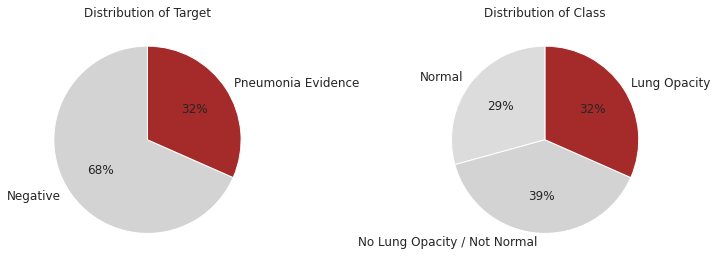

In [7]:
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(121)
g = (train_labels['Target'].value_counts()
    .plot(kind = 'pie', autopct = '%.0f%%', 
          labels = ['Negative', 'Pneumonia Evidence'], 
          colors = ['lightgray', 'brown'], 
          startangle = 90, 
          title = 'Distribution of Target', fontsize = 12)
    .set_ylabel(''))
ax = fig.add_subplot(122)
g = (class_info['class'].value_counts().sort_index(ascending = False)
    .plot(kind = 'pie', autopct = '%.0f%%', 
          colors = ['gainsboro', 'lightgray', 'brown'], 
          startangle = 90, title = 'Distribution of Class', 
          fontsize = 12)
    .set_ylabel(''))
plt.tight_layout()

Grouping by patient and checking number of bounding boxes for every unique patient

In [8]:
bounding_boxes = train_labels.groupby('patientId').size().to_frame('number_of_boxes').reset_index()
train_labels = train_labels.merge(bounding_boxes, on = 'patientId', how = 'left')
print('Number of unique patient ids: {}'.format(len(bounding_boxes)))
print('\nNumber of patient ids per bounding boxes')
(bounding_boxes.groupby('number_of_boxes')
.size()
.to_frame('number_of_patient_ids_per_boxes')
.reset_index()
.set_index('number_of_boxes')
.sort_values(by = 'number_of_boxes'))

Number of unique patient ids: 26684

Number of patient ids per bounding boxes


number_of_patient_ids_per_boxes
number_of_boxes                                 
1                                          23286
2                                           3266
3                                            119
4                                             13

Let's check how each patientId is mapped to the class type

In [9]:
print('Each patient Id is associated with {} class'.format(class_info.groupby(['patientId'])['class'].nunique().max()))

Each patient Id is associated with 1 class


Merging "Train Labels" and "Class Info"

In [10]:
train_class = pd.concat([train_labels, class_info['class']], axis = 1)
print('Shape of the dataset after the merge: {}'.format(train_class.shape))

Shape of the dataset after the merge: (30227, 8)


Analysis based on reading of images

In [11]:
train_imgs = os.path.join(data_folder + 'stage_2_train_images/')
test_imgs = os.path.join(data_folder + 'stage_2_test_images/')

sample_patient_id = train_labels['patientId'][0]
dcm_file = train_imgs + '{}.dcm'.format(sample_patient_id)
dcm_data = dcm.read_file(dcm_file)

print(dcm_data)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

We will read the training images file names and path, determine the total number of images and observe the features of this data set

In [12]:
from glob import glob
images = pd.DataFrame({'path': glob(os.path.join(train_imgs, '*.dcm'))})
images['patientId'] = images['path'].map(lambda x: os.path.splitext(os.path.basename(x))[0])
print('There are ',images.shape[0],'images in the training folder')
print('The columns ',list(images.columns),'are present in the training images dataframe')
assert images.shape[0] == len(list(set(train_class['patientId']))), 'Number of training images should be equal to the unique patientIds we have'

There are  26684 images in the training folder
The columns  ['path', 'patientId'] are present in the training images dataframe


Let us merge the image dataframe that we read just now and the 'Train Class' dataframe read earlier, using 'Patient Id' as the key 

In [13]:
train_class = train_class.merge(images, on = 'patientId', how = 'left')
print('Shape of the `train_class` dataframe after merge: {}'.format(train_class.shape))
del images

Shape of the `train_class` dataframe after merge: (30227, 9)


Get features from the training images and save the feature engineered dataframe for future use

In [14]:
# Helper function to get additional features from dicom images
def get_tags(data, path):
    images = os.listdir(path)
    for _, name in tqdm_notebook(enumerate(images)):
        img_path = os.path.join(path, name)
        img_data = dcm.read_file(img_path)
        idx = (data['patientId'] == img_data.PatientID)
        data.loc[idx,'PatientSex'] = img_data.PatientSex
        data.loc[idx,'PatientAge'] = pd.to_numeric(img_data.PatientAge)
        data.loc[idx,'BodyPartExamined'] = img_data.BodyPartExamined
        data.loc[idx,'ViewPosition'] = img_data.ViewPosition
        data.loc[idx,'Modality'] = img_data.Modality


In [15]:
print('Get features such as {} from training images'.format(('PatientSex', 'PatientAge', 'BodyPartExamined', 'ViewPosition', 'Modality')))
get_tags(train_class, train_imgs)

Get features such as ('PatientSex', 'PatientAge', 'BodyPartExamined', 'ViewPosition', 'Modality') from training images


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [16]:
out_dir = os.path.join('./output/')
if not os.path.exists(out_dir): os.makedirs(out_dir)

train_class.to_pickle('./output/train_feature_engineered.pkl')

Let us load the consolidated data set and observe its shape

In [17]:
train_class = pd.read_pickle('./output/train_feature_engineered.pkl')
train_class.shape

(30227, 14)

In [18]:
train_class.head()

patientId      x  ...  ViewPosition  Modality
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN  ...            PA        CR
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN  ...            PA        CR
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN  ...            AP        CR
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN  ...            PA        CR
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  ...            AP        CR

[5 rows x 14 columns]

In [19]:
print('Unique `Body Parts Examined`: {}'.format(train_class['BodyPartExamined'].unique()[0]))
print('Unique `Modality`: {}'.format(train_class['Modality'].unique()[0]));

Unique `Body Parts Examined`: CHEST
Unique `Modality`: CR


Let us observe the distribution of `ViewPosition` when Target is 1
The distribution is almost the same, but where there's a Pneumonia Evidence `ViewPosition` is `AP`
AP: Anterior/Posterior, PA: Posterior/Anterior

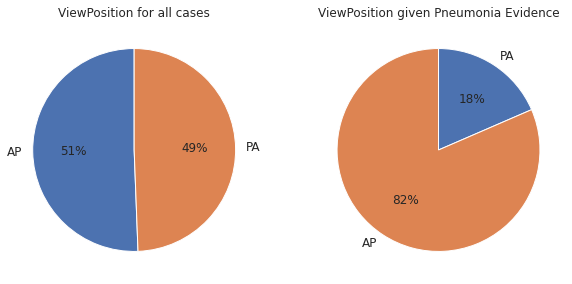

In [20]:
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(121)
g = (train_class['ViewPosition'].value_counts()
    .plot(kind = 'pie', autopct = '%.0f%%',  
          startangle = 90,
          title = 'ViewPosition for all cases', 
          fontsize = 12)
    .set_ylabel(''))
ax = fig.add_subplot(122)
g = (train_class.loc[train_class['Target'] == 1, 'ViewPosition']
     .value_counts().sort_index(ascending = False)
    .plot(kind = 'pie', autopct = '%.0f%%', 
          startangle = 90, counterclock = False, 
          title = 'ViewPosition given Pneumonia Evidence', 
          fontsize = 12)
    .set_ylabel(''))

Plot x and y centers of bounding boxes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


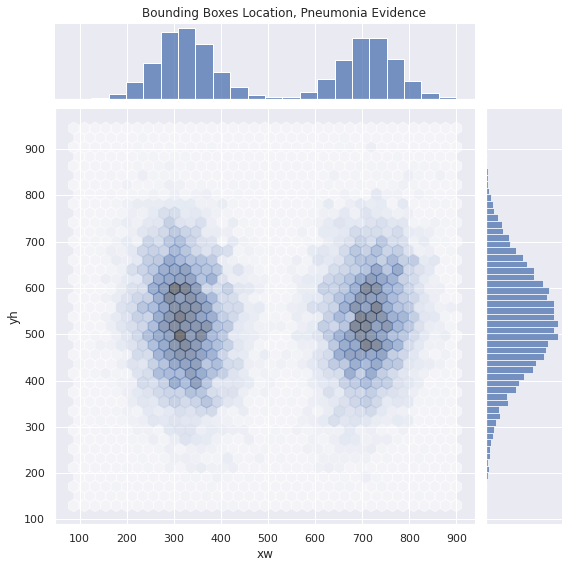

In [21]:
# Creating a dataframe with columns for center of the rectangles
bounding_boxes = train_class[train_class['Target'] == 1]
bounding_boxes['xw'] = bounding_boxes['x'] + bounding_boxes['width'] / 2
bounding_boxes['yh'] = bounding_boxes['y'] + bounding_boxes['height'] / 2

g = sns.jointplot(x = bounding_boxes['xw'], y = bounding_boxes['yh'], data = bounding_boxes, 
                  kind = 'hex', alpha = 0.5, height = 8)
plt.suptitle('Bounding Boxes Location, Pneumonia Evidence')
plt.tight_layout()
plt.subplots_adjust(top = 0.95)
plt.show()

Let us explore the bounding boxes centers for ViewPositions for a random sample

In [22]:
def bboxes_scatter(df1, df2, text1, text2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (13, 8))
    fig.subplots_adjust(top = 0.85)
    fig.suptitle('Plotting centers of lung opacity\n{} & {}'.format(text1, text2))
    df1.plot.scatter(x = 'xw', y = 'yh', ax = ax1, alpha = 0.8, marker = '.', 
                   xlim = (0, 1024), ylim = (0, 1024), color = 'green')
    ax1.set_title('Centers of Lung Opacity\n{}'.format(text1))
    for i, row in df1.iterrows():
        ax1.add_patch(Rectangle(xy = (row['x'], row['y']),
                            width = row['width'], height = row['height'], 
                            alpha = 3.5e-3, color = 'yellow'))
    plt.title('Centers of Lung Opacity\n{}'.format(text2))
    df2.plot.scatter(x = 'xw', y = 'yh', ax = ax2, alpha = 0.8, marker = '.',
                   color = 'brown',  xlim = (0, 1024), ylim = (0, 1024))
    ax2.set_title('Centers of Lung Opacity\n{}'.format(text2))
    for i, row in df2.iterrows():
        ax2.add_patch(Rectangle(xy = (row['x'], row['y']),
                             width = row['width'], height = row['height'],
                             alpha = 3.5e-3, 
                             color = 'yellow'))
    plt.show()

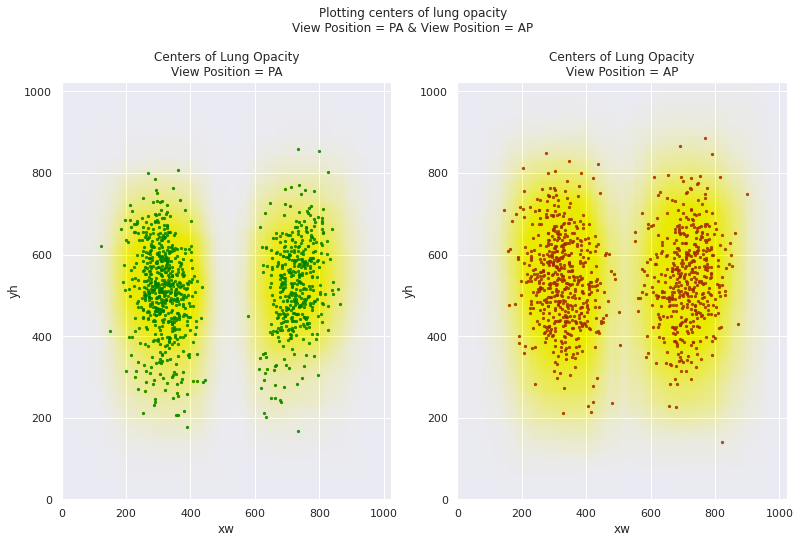

In [23]:
df1 = bounding_boxes[bounding_boxes['ViewPosition'] == 'PA'].sample(1000)
df2 = bounding_boxes[bounding_boxes['ViewPosition'] == 'AP'].sample(1000)
bboxes_scatter(df1, df2, 'View Position = PA', 'View Position = AP')

Let us analyze the distribution of Patients' age and check for outliers

Minimum age: 1.0
Maximum age: 155.0
75th Percentile : 59.0
Age in upper whisker for box plot: 84.0



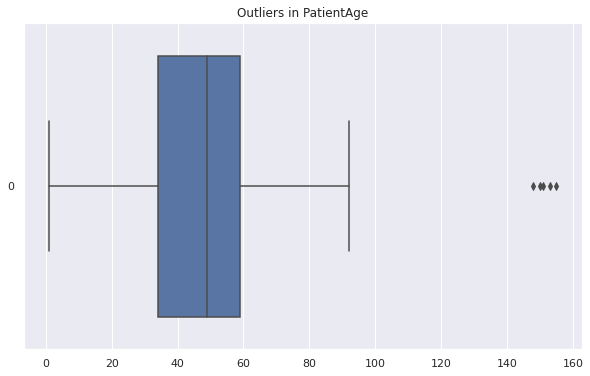

In [24]:
print('Minimum age: {}'.format(train_class['PatientAge'].min()))
print('Maximum age: {}'.format(train_class['PatientAge'].max()))
print('75th Percentile : {}'.format(train_class['PatientAge'].quantile(0.75)))
print('Age in upper whisker for box plot: {}'.format(train_class['PatientAge'].quantile(0.75) + (train_class['PatientAge'].quantile(0.75) - train_class['PatientAge'].quantile(0.25))))
print()
fig = plt.figure(figsize = (10, 6))
ax = sns.boxplot(data = train_class['PatientAge'], orient = 'h').set_title('Outliers in PatientAge')

We can make use of pd.clip() to trim value to a specified lower and upper threshold. So an upper threshold of 100 in PatientAge would mean those outlier values being converted to 100.

In [25]:
train_class['PatientAge'] = train_class['PatientAge'].clip(train_class['PatientAge'].min(), 100)
train_class['PatientAge'].describe().astype(int)

count    30227
mean        46
std         16
min          1
25%         34
50%         49
75%         59
max        100
Name: PatientAge, dtype: int64

Let us get the distribution of PatientAge overall and where there is evidence of Pneumonia

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


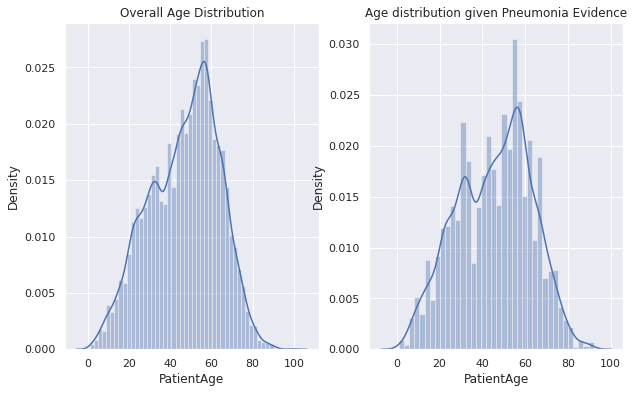

In [26]:
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(121)
g = (sns.distplot(train_class['PatientAge'])
    .set_title('Overall Age Distribution'))
ax = fig.add_subplot(122)
g = (sns.distplot(train_class.loc[train_class['Target'] == 1, 'PatientAge'])
    .set_title('Age distribution given Pneumonia Evidence'))



```
# This is formatted as code
```

Let us bin Age values into discrete intervals, used when the need is to segment and sort data values into bins. This takes the Age from a continuous variable to a categorical variable.

In [27]:
train_class['AgeBins'] = pd.cut(train_class['PatientAge'], bins = 4, precision = 0, labels = ['<=26', '<=50', '<=75', '<=100'])
train_class['AgeBins'].value_counts()

<=75     13318
<=50     12157
<=26      3972
<=100      780
Name: AgeBins, dtype: int64

Let's observe the Value counts of the binned Ages

Counts of Age Bins, Overall  Counts of Age Bins, Target=1
<=26                          3972                          1478
<=50                         12157                          3917
<=75                         13318                          3895
<=100                          780                           265

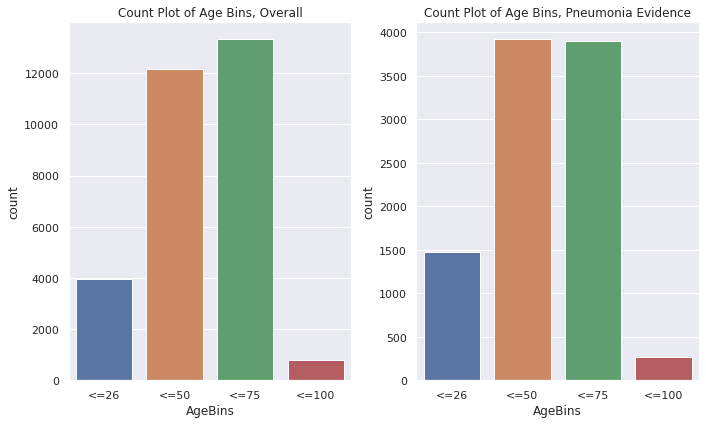

In [28]:
display(pd.concat([train_class['AgeBins'].value_counts().sort_index().rename('Counts of Age Bins, Overall'), 
                   train_class.loc[train_class['Target'] == 1, 'AgeBins'].value_counts().sort_index().rename('Counts of Age Bins, Target=1')], axis = 1))
print()
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 6))
g = sns.countplot(x = train_class['AgeBins'], ax = ax1).set_title('Count Plot of Age Bins, Overall')
g = sns.countplot(x = train_class.loc[train_class['Target'] == 1, 'AgeBins'], ax = ax2).set_title('Count Plot of Age Bins, Pneumonia Evidence')
plt.tight_layout()

We will explore the bounding boxes centers for AgeBins for a random sample

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


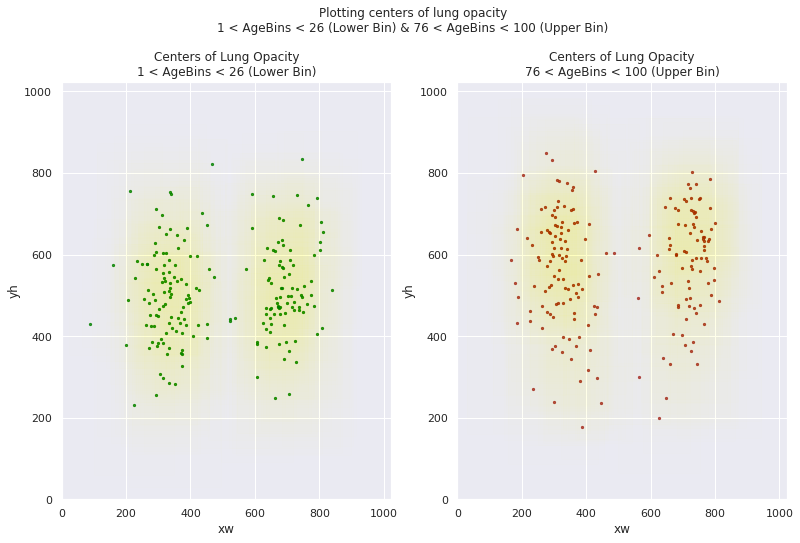

In [29]:
# Creating a dataframe with columns for center of the rectangles
bounding_boxes = train_class[train_class['Target'] == 1]
bounding_boxes['xw'] = bounding_boxes['x'] + bounding_boxes['width'] / 2
bounding_boxes['yh'] = bounding_boxes['y'] + bounding_boxes['height'] / 2

df1 = bounding_boxes[bounding_boxes['AgeBins'] == '<=26'].sample(200)
df2 = bounding_boxes[bounding_boxes['AgeBins'] == '<=100'].sample(200)
bboxes_scatter(df1, df2, '1 < AgeBins < 26 (Lower Bin)', '76 < AgeBins < 100 (Upper Bin)')

Let us check gender-wise distribution for cases with Pneumonia Evidence

% Gender, Overall  % Gender, Target=1
F               0.43                0.42
M               0.57                0.58

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


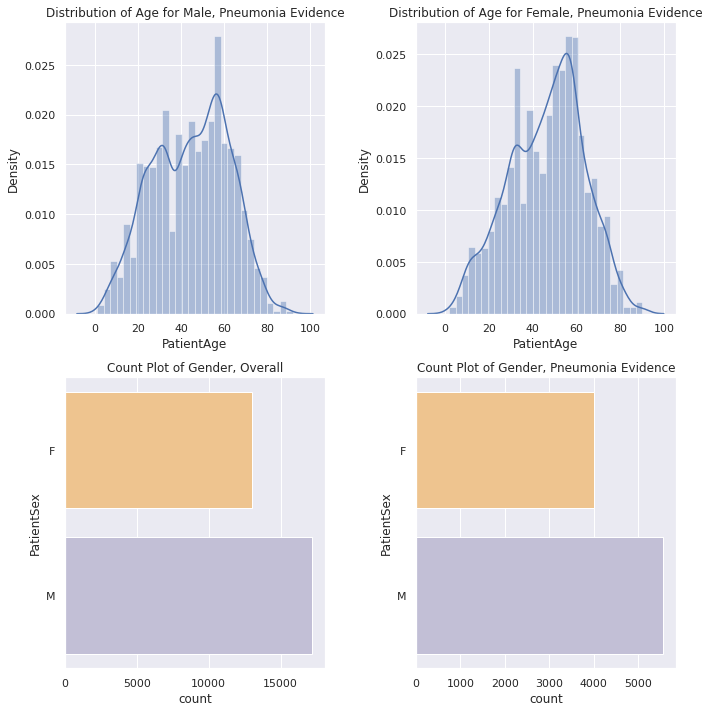

In [30]:
display(pd.concat([train_class['PatientSex'].value_counts(normalize = True).round(2).sort_values().rename('% Gender, Overall'), 
                   train_class.loc[(train_class['Target'] == 1), 'PatientSex']
                   .value_counts(normalize = True).round(2).sort_index().rename('% Gender, Target=1')], axis = 1))

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (10, 10))
g = sns.distplot(train_class.loc[(train_class['Target'] == 1) & (train_class['PatientSex'] == 'M'), 'PatientAge'], ax = ax1).set_title('Distribution of Age for Male, Pneumonia Evidence')
g = sns.distplot(train_class.loc[(train_class['Target'] == 1) & (train_class['PatientSex'] == 'F'), 'PatientAge'], ax = ax2).set_title('Distribution of Age for Female, Pneumonia Evidence')
g = sns.countplot(y = train_class['PatientSex'], ax = ax3, palette = 'PuOr').set_title('Count Plot of Gender, Overall')
g = sns.countplot(y = train_class.loc[(train_class['Target'] == 1), 'PatientSex'], ax = ax4, palette = 'PuOr').set_title('Count Plot of Gender, Pneumonia Evidence')
plt.tight_layout()

Let us explore bounding boxes centers for `PatientSex` for a random sample

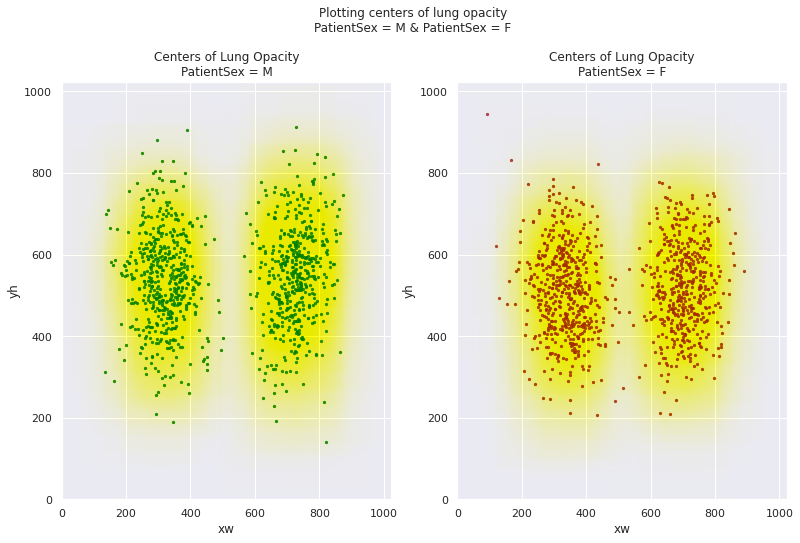

In [31]:
df1 = bounding_boxes[bounding_boxes['PatientSex'] == 'M'].sample(1000)
df2 = bounding_boxes[bounding_boxes['PatientSex'] == 'F'].sample(1000)
bboxes_scatter(df1, df2, 'PatientSex = M', 'PatientSex = F')

In [32]:
train_class.drop(['BodyPartExamined', 'Modality'], inplace = True, axis = 1)
train_class.to_pickle('./output/train_class_features.pkl')
display(train_class.shape, train_class.head())

(30227, 13)

patientId      x  ...  ViewPosition  AgeBins
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN  ...            PA     <=75
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN  ...            PA     <=50
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN  ...            AP     <=26
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN  ...            PA     <=50
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  ...            AP     <=50

[5 rows x 13 columns]

Check some random samples from training data
Checking some random samples as below:

Different classes i.e. Normal, No Lung Opacity / Not Normal and Lung Opacity
Two view positions that we have in the dataset
For the one with Pneumonia Evidence and age = 92
Now, we will make use of custom module (eda) and function (plot_dicom_images) already imported earlier to visualize the images.

Checking sample for different classes


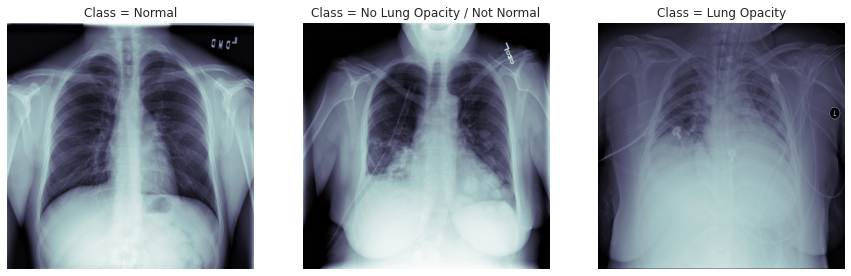

In [33]:
print('Checking sample for different classes')
sample1 = train_class.loc[train_class['class'] == 'Normal'].iloc[0]
sample2 = train_class.loc[train_class['class'] == 'No Lung Opacity / Not Normal'].iloc[0]
sample3 = train_class.loc[train_class['class'] == 'Lung Opacity'].iloc[1]
ds1 = dcm.dcmread(sample1['path'])
ds2 = dcm.dcmread(sample2['path'])
ds3 = dcm.dcmread(sample3['path'])

f, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize = (15, 8))
ax1.imshow(ds1.pixel_array, cmap = plt.cm.bone)
ax1.set_title('Class = Normal')
ax1.axis('off')
ax2.imshow(ds2.pixel_array, cmap = plt.cm.bone)
ax2.set_title('Class = No Lung Opacity / Not Normal')
ax2.axis('off')
ax3.imshow(ds3.pixel_array, cmap = plt.cm.bone)
ax3.set_title('Class = Lung Opacity')
ax3.axis('off')
plt.show()

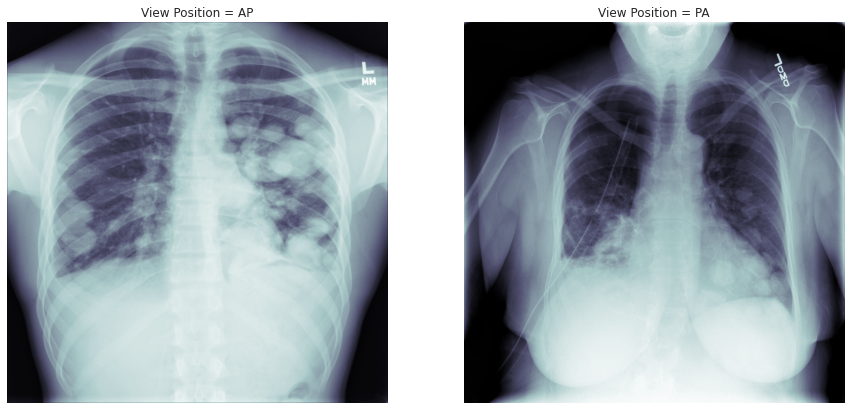

In [34]:
sample4 = train_class.loc[(train_class['ViewPosition'] == 'AP')].iloc[0]
sample5 = train_class.loc[(train_class['ViewPosition'] == 'PA')].iloc[0]
ds4 = dcm.dcmread(sample4['path'])
ds5 = dcm.dcmread(sample5['path'])

f, ((ax1, ax2)) = plt.subplots(1, 2, figsize = (15, 8))
ax1.imshow(ds4.pixel_array, cmap = plt.cm.bone)
ax1.set_title('View Position = AP')
ax1.axis('off')
ax2.imshow(ds5.pixel_array, cmap = plt.cm.bone)
ax2.set_title('View Position = PA')
ax2.axis('off')
plt.show()

In [35]:
# Helper function to plot the dicom images
def plot_dicom_images(data, df, img_path):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3, 3, figsize = (16, 18))
    for i, row in enumerate(img_data):
        image = row['patientId'] + '.dcm'
        path = os.path.join(img_path, image)
        data = dcm.read_file(path)
        rows = df[df['patientId'] == row['patientId']]
        age = rows.PatientAge.unique().tolist()[0]
        sex = data.PatientSex
        part = data.BodyPartExamined
        vp = data.ViewPosition
        modality = data.Modality
        data_img = dcm.dcmread(path)
        ax[i//3, i%3].imshow(data_img.pixel_array, cmap = plt.cm.bone)
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nAge: {}, Sex: {}, Part: {}, VP: {}, Modality: {}\nTarget: {}, Class: {}\nWindow: {}:{}:{}:{}'\
                              .format(row['patientId'], age, sex, part, 
                                      vp, modality, row['Target'], 
                                      row['class'], row['x'], 
                                      row['y'], row['width'],
                                      row['height']))
        box_data = list(rows.T.to_dict().values())
        for j, row in enumerate(box_data):
            ax[i//3, i%3].add_patch(Rectangle(xy = (row['x'], row['y']),
                      width = row['width'], height = row['height'], 
                      color = 'blue', alpha = 0.15)) 
    plt.show()

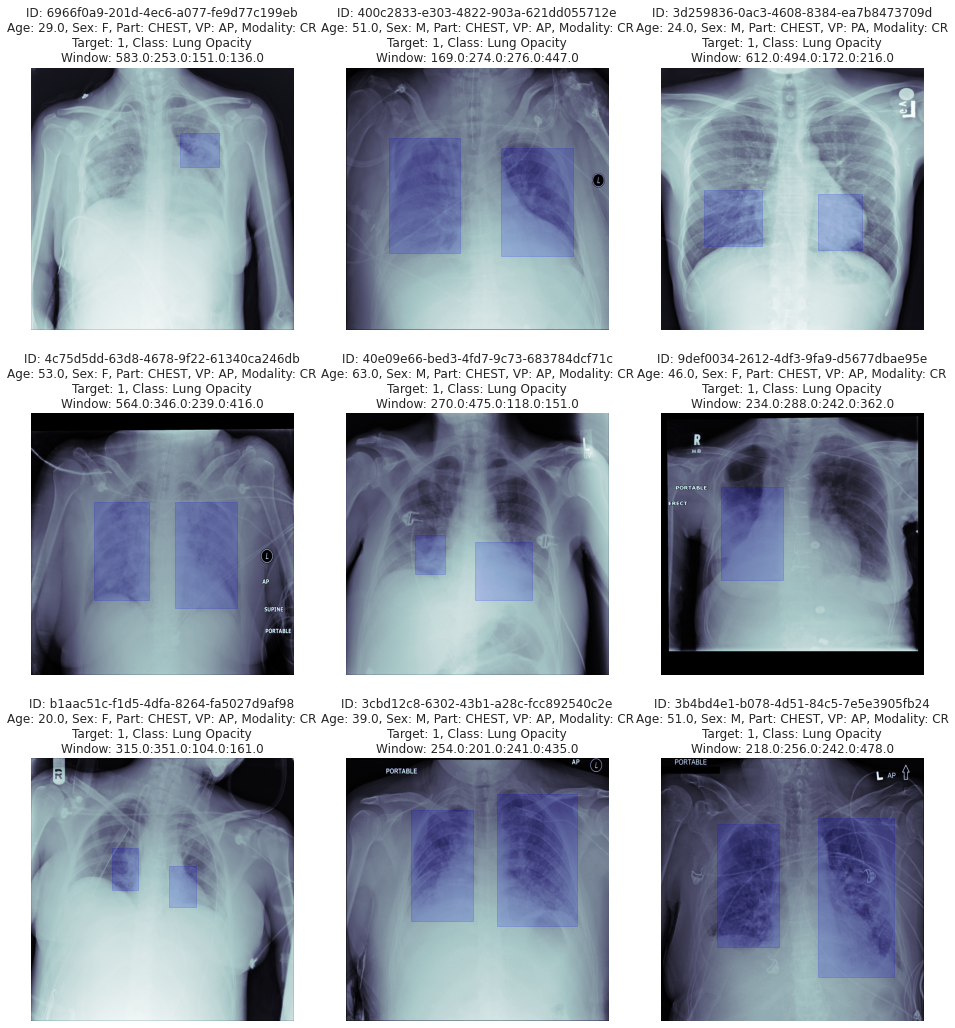

In [36]:
plot_dicom_images(data = train_class.loc[(train_class['Target'] == 1)].sample(9), 
                  df = train_class, img_path = train_imgs)

## Model Building using Mask R-CNN

In [37]:
c=math.ceil(train_class.shape[0]*0.7)
train_df,val_df=train_class[:c],train_class[c:]
print(train_df.shape, val_df.shape)

(21159, 13) (9068, 13)


In [38]:
transform = alb.Compose([
        alb.RandomRotate90(),
        alb.Flip(),
        alb.Transpose(),
        alb.OneOf([
            alb.IAAAdditiveGaussianNoise(),
            alb.GaussNoise(),
        ], p=0.2),
        alb.OneOf([
            alb.MotionBlur(p=.2),
            alb.MedianBlur(blur_limit=3, p=0.1),
            alb.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        alb.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        alb.OneOf([
            alb.OpticalDistortion(p=0.3),
            alb.GridDistortion(p=.1),
            alb.IAAPiecewiseAffine(p=0.3),
        ], p=0.2),
        alb.OneOf([
            alb.CLAHE(clip_limit=2),
            alb.IAASharpen(),
            alb.IAAEmboss(),
            alb.RandomBrightnessContrast(),            
        ], p=0.3),
        alb.HueSaturationValue(p=0.3),
    ])

/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:252: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:290: FutureWarning: This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead
  warnings.warn("This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:222: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:165: FutureWarning: This augmentation is deprecated. Please use Emboss instead
  warnings.warn("This augmentation is deprecated. Please use Embo

In [39]:
trainsize=2000
valsize=int(0.25*trainsize)
trainpartial=train_class[:trainsize]
valpartial=val_df[:valsize]
print('Distribution of labels in the train data are ', 
      (trainpartial.Target.value_counts().values/trainpartial.Target.value_counts().values.sum())*100)
print('Distribution of labels in the validation data are ', 
      (valpartial.Target.value_counts().values/valpartial.Target.value_counts().values.sum())*100)

Distribution of labels in the train data are  [57.15 42.85]
Distribution of labels in the validation data are  [53.2 46.8]


In [40]:
def iou_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(float(y_true) * float(y_pred))
    score = (intersection + 1.) / (tf.reduce_sum(float(y_true)) + tf.reduce_sum(float(y_pred)) - intersection + 1.)
    return 1 - score

# combine bce loss and iou loss
def iou_bce_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)

# mean iou as a metric
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(float(y_true) * float(y_pred), axis=[1])
    union = tf.reduce_sum(float(y_true),axis=[1]) + tf.reduce_sum(float(y_pred),axis=[1])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

In [41]:
if not os.path.exists('/content/'+'Mask_RCNN'):
  !git clone https://www.github.com/matterport/Mask_RCNN.git
os.chdir('/content/'+'Mask_RCNN')
!git clone https://github.com/madhu367/Capstone_Pneumonia_Detection.git
!mv /content/Mask_RCNN/Capstone_Pneumonia_Detection/model.py ./mrcnn/

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 25.51 MiB/s, done.
Resolving deltas: 100% (562/562), done.
Cloning into 'Capstone_Pneumonia_Detection'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 28 (delta 7), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (28/28), done.


In [42]:
!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!ls -lh mask_rcnn_coco.h5

-rw-r--r-- 1 root root 246M Nov 26  2017 mask_rcnn_coco.h5


In [43]:
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
from mrcnn.visualize import display_instances

Using TensorFlow backend.


In [44]:
# Root directory of the project
mask_rcnn_dir = os.path.join(data_folder+"Mask_RCNN/")
sys.path.append(mask_rcnn_dir)  # To find local version of the library
# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(mask_rcnn_dir, "mask_rcnn_coco.h5")
# Directory to save logs and model checkpoints
DEFAULT_LOGS_DIR = os.path.join(data_folder, "logs")

In [45]:
def get_dicom_fps(dicom_dir):
    dicom_fps = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(dicom_fps))

def parse_dataset(dicom_dir, anns): 
    image_fps = get_dicom_fps(dicom_dir)
    image_annotations = {fp: [] for fp in image_fps}
    for index, row in anns.iterrows(): 
        fp = os.path.join(dicom_dir, row['patientId']+'.dcm')
        image_annotations[fp].append(row)
    return image_fps, image_annotations 

In [46]:
# The following parameters have been selected to reduce running time for demonstration purposes 
# These are not optimal 

class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
    
    # Give the configuration a recognizable name  
    NAME = 'pneumonia'
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 2  # background + 1 pneumonia classes
    
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    #RPN_ANCHOR_SCALES = (32, 64, 128, 256)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 4
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.78  ## match target distribution
    DETECTION_NMS_THRESHOLD = 0.01

    STEPS_PER_EPOCH = 200

config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.78
DETECTION_NMS_THRESHOLD        0.01
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [81]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('pneumonia', 1, 'Lung Opacity')
        
        # add images 
        for i, fp in enumerate(image_fps):
            annotations = image_annotations[fp]
            self.add_image('pneumonia', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = dcm.read_file(fp)
        image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

In [48]:
anns = pd.read_csv(os.path.join(data_folder, 'stage_2_train_labels.csv'))
anns.head()

patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1

In [49]:
import glob
image_fps, image_annotations = parse_dataset(train_imgs, anns=anns)

In [50]:
ds = dcm.read_file(image_fps[0]) # read dicom image from filepath 
image = ds.pixel_array # get image array

In [51]:
import random
image_fps_list = list(image_fps)
random.seed(42)
random.shuffle(image_fps_list)
val_size = 1500
image_fps_val = image_fps_list[:val_size]
image_fps_train = image_fps_list[val_size:]

print(len(image_fps_train), len(image_fps_val))
# print(image_fps_val[:6])

25184 1500


In [52]:
# prepare the training dataset
ORIG_SIZE = 1024
dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

In [53]:
# Show annotation(s) for a DICOM image 
test_fp = random.choice(image_fps_train)
image_annotations[test_fp]

[patientId    d9c868ad-52d6-4d3d-9b2b-05534e1cee81
 x                                             265
 y                                             723
 width                                         166
 height                                        113
 Target                                          1
 Name: 24244, dtype: object]

In [54]:
# prepare the validation dataset
dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

(1024, 1024, 3)
/content/stage_2_train_images/bc4f2fce-e1dd-4d50-bdb5-103c25f46c8b.dcm
[1]


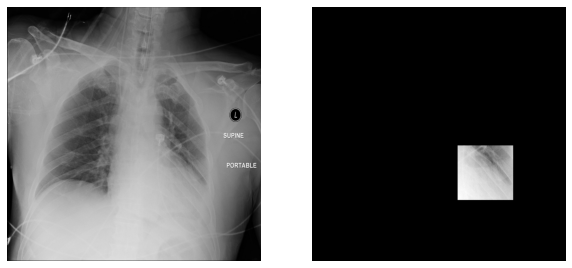

In [55]:
class_ids = [0]
while class_ids[0] == 0:  ## look for a mask
    image_id = random.choice(dataset_train.image_ids)
    image_fp = dataset_train.image_reference(image_id)
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)

print(image.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += image[:, :, 0] * mask[:, :, i]
plt.imshow(masked, cmap='gray')
plt.axis('off')

print(image_fp)
print(class_ids)

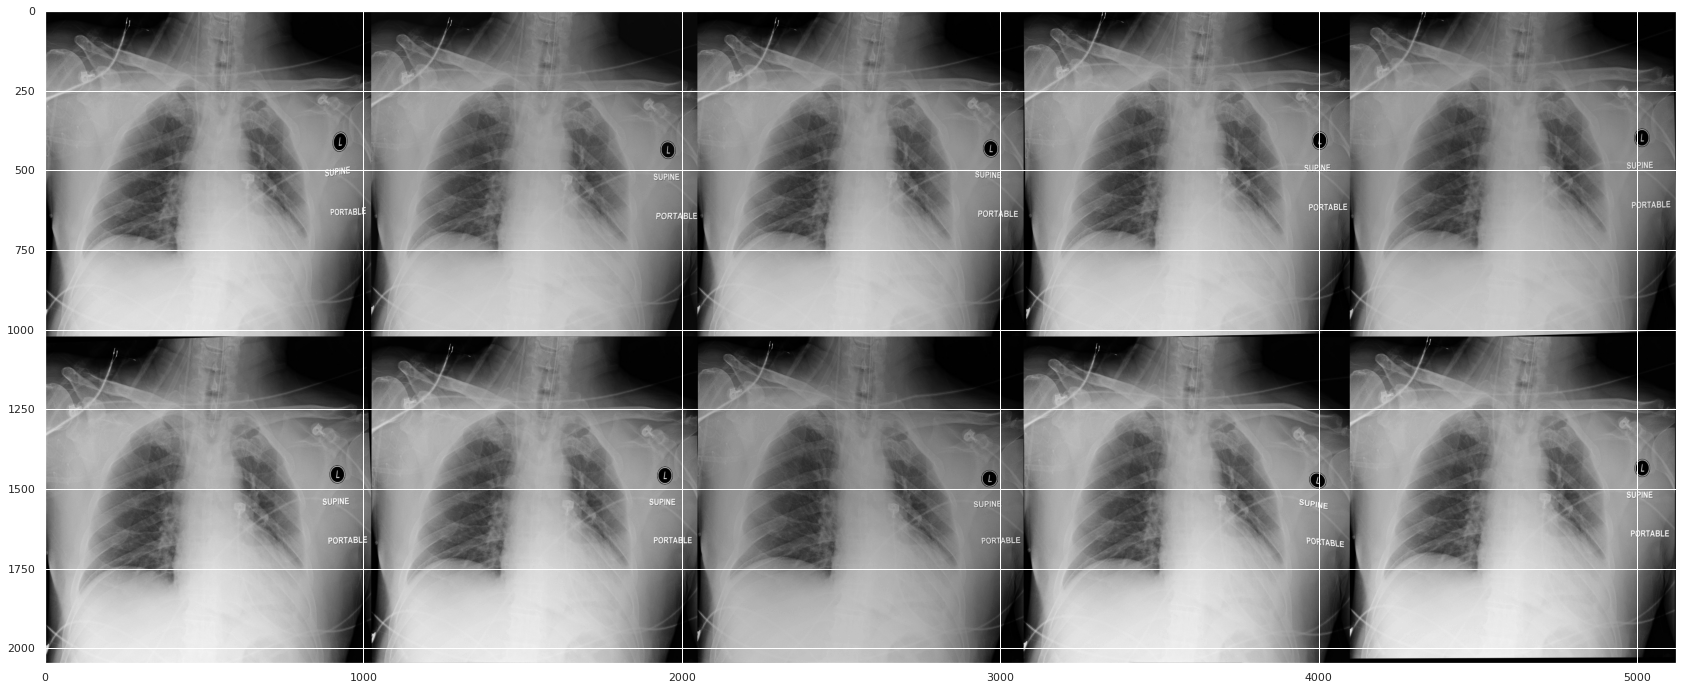

In [56]:
from imgaug import augmenters as iaa

# Image augmentation (light but constant)
augmentation = iaa.Sequential([
    iaa.OneOf([ ## geometric transform
        iaa.Affine(
            scale={"x": (0.98, 1.02), "y": (0.98, 1.04)},
            translate_percent={"x": (-0.02, 0.02), "y": (-0.04, 0.04)},
            rotate=(-2, 2),
            shear=(-1, 1),
        ),
        iaa.PiecewiseAffine(scale=(0.001, 0.025)),
    ]),
    iaa.OneOf([ ## brightness or contrast
        iaa.Multiply((0.9, 1.1)),
        iaa.ContrastNormalization((0.9, 1.1)),
    ]),
    iaa.OneOf([ ## blur or sharpen
        iaa.GaussianBlur(sigma=(0.0, 0.1)),
        iaa.Sharpen(alpha=(0.0, 0.1)),
    ]),
])

# test on the same image as above
imggrid = augmentation.draw_grid(image[:, :, 0], cols=5, rows=2)
plt.figure(figsize=(30, 12))
_ = plt.imshow(imggrid[:, :, 0], cmap='gray')

In [57]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=data_folder)

# Exclude the last layers because they require a matching
# number of classes

model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc","mrcnn_bbox", "mrcnn_mask"])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [58]:
import warnings 
warnings.filterwarnings("ignore")

LEARNING_RATE = 0.006
# ## train heads with higher lr to speedup the learning

model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE*2,
            epochs=2,
            layers='heads',
            augmentation=None)  

history = model.keras_model.history.history


Starting at epoch 0. LR=0.012

Checkpoint Path: /content/pneumonia20210612T1512/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4        

In [59]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE,
            epochs=5,
            layers='all',
            augmentation=augmentation
            )

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 2. LR=0.006

Checkpoint Path: /content/pneumonia20210612T1512/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b         

In [60]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE/5,
            epochs=7,
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 5. LR=0.0012000000000000001

Checkpoint Path: /content/pneumonia20210612T1512/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_b

In [61]:
epochs = range(1,len(next(iter(history.values())))+1)
pd.DataFrame(history, index=epochs)

val_loss  val_rpn_class_loss  ...  mrcnn_bbox_loss  mrcnn_mask_loss
1  1.651716            0.055982  ...         0.560125         0.416817
2  2.050475            0.048442  ...         0.492842         0.390692
3  1.788579            0.069244  ...         0.471747         0.399556
4  1.997178            0.042126  ...         0.432753         0.389380
5  1.346194            0.044492  ...         0.422544         0.382098
6  1.351709            0.039370  ...         0.392888         0.375440
7  1.444015            0.030643  ...         0.370086         0.367159

[7 rows x 12 columns]

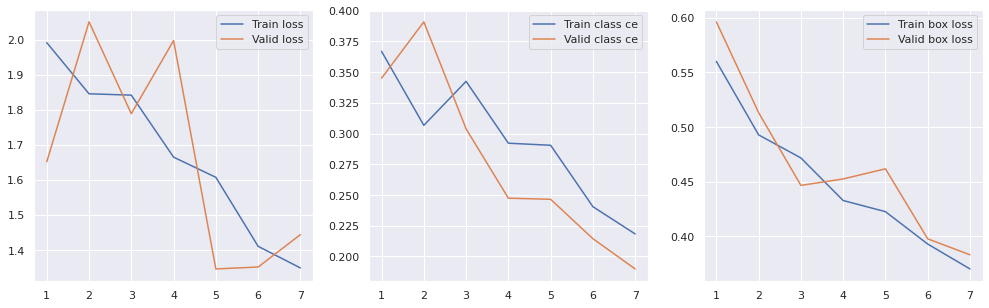

In [62]:
plt.figure(figsize=(17,5))

plt.subplot(131)
plt.plot(epochs, history["loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(epochs, history["mrcnn_class_loss"], label="Train class ce")
plt.plot(epochs, history["val_mrcnn_class_loss"], label="Valid class ce")
plt.legend()
plt.subplot(133)
plt.plot(epochs, history["mrcnn_bbox_loss"], label="Train box loss")
plt.plot(epochs, history["val_mrcnn_bbox_loss"], label="Valid box loss")
plt.legend()

plt.show()

In [63]:
best_epoch = np.argmin(history["val_loss"])
print("Best Epoch:", best_epoch + 1, history["val_loss"][best_epoch])

Best Epoch: 5 1.346193552017212


In [64]:
# select trained model 
dir_names = next(os.walk(model.model_dir))[1]
key = config.NAME.lower()
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)

if not dir_names:
    import errno
    raise FileNotFoundError(
        errno.ENOENT,
        "Could not find model directory under {}".format(self.model_dir))
    
fps = []
# Pick last directory
for d in dir_names: 
    dir_name = os.path.join(model.model_dir, d)
    # Find the last checkpoint
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
    checkpoints = sorted(checkpoints)
    if not checkpoints:
        print('No weight files in {}'.format(dir_name))
    else:
        checkpoint = os.path.join(dir_name, checkpoints[best_epoch])
        fps.append(checkpoint)

model_path = sorted(fps)[-1]
print('Found model {}'.format(model_path))

Found model /content/pneumonia20210612T1512/mask_rcnn_pneumonia_0005.h5


In [66]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=data_folder)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)



Instructions for updating:
Use `tf.cast` instead.
Loading weights from  /content/pneumonia20210612T1512/mask_rcnn_pneumonia_0005.h5
Re-starting from epoch 5


In [67]:
# set color for class
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors

(256, 256, 3)
(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)

*** No instances to display *** 



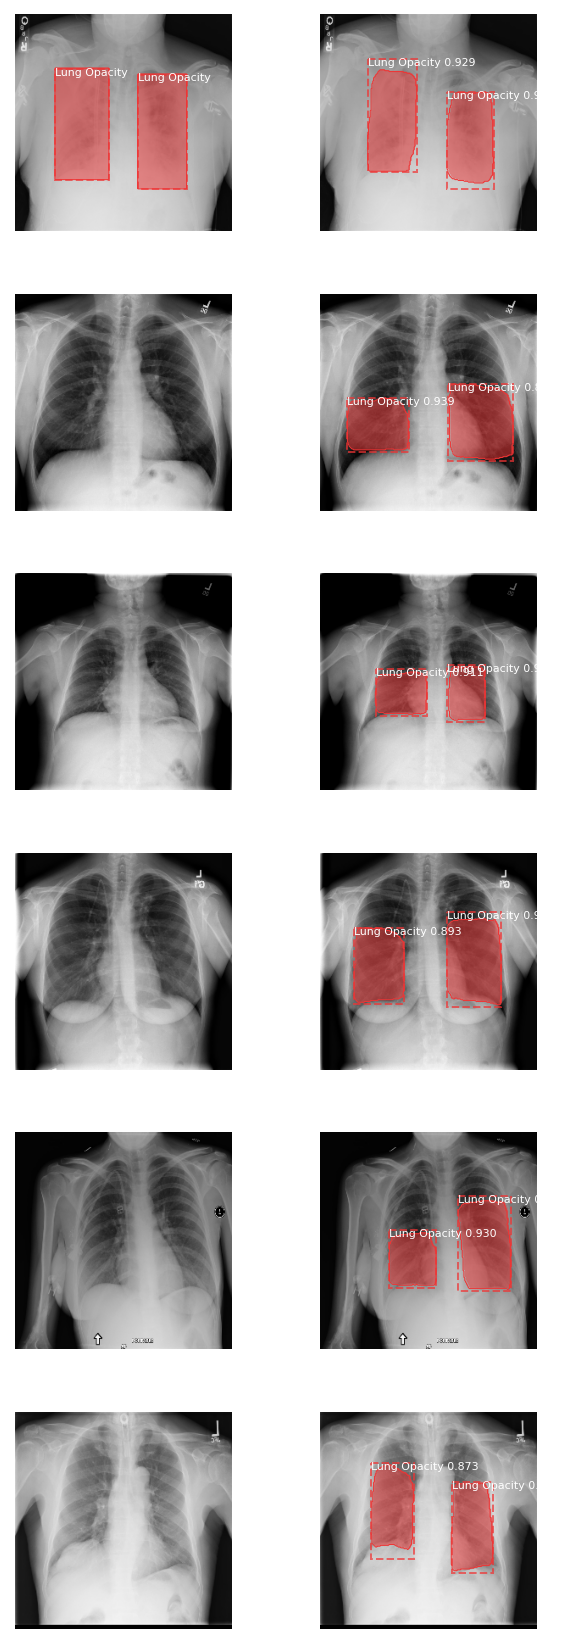

In [69]:
# Show few example of ground truth vs. predictions on the validation dataset 
dataset = dataset_val
fig = plt.figure(figsize=(10, 30))

for i in range(6):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
    
    print(original_image.shape)
    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])

In [71]:
# Get filenames of test dataset DICOM images
test_image_fps = get_dicom_fps(test_imgs)

In [86]:
import pydicom

submission_fp = os.path.join(data_folder, 'submission.csv')
predict(test_image_fps, filepath=submission_fp)
print(submission_fp)

100%|██████████| 3000/3000 [09:22<00:00,  5.33it/s]

/content/submission.csv


In [87]:
output = pd.read_csv(submission_fp)
output.head(60) 

patientId                                   PredictionString
0   03cc6b7a-4eef-46e3-98e0-fe3990325b36                                                NaN
1   2c826ec1-41d0-401b-ada3-0f92d194c716                                                NaN
2   1ed7a23f-654c-4c0c-98ef-fd8d771cd901                                                NaN
3   248652fe-8a0b-4461-af7d-8e684275315b                                                NaN
4   23a26c71-73e0-4cb2-b2ae-661a04c696dc                                                NaN
5   2f9fc03f-4ee7-41f8-b072-3c5f3f4e90e2                                                NaN
6   c0460ef6-44a3-45ef-beb2-ed1b13c88e5e                                                NaN
7   2d6778ad-3faf-4d8a-9e90-a5aed71ac75e                                                NaN
8   2bd7a6e1-bc2b-402d-801c-0026d21e81bd                       0.95 548.0 384.0 256.0 396.0
9   1a65e7f7-d13e-4dda-b680-be66a4db6a2a                       0.96 568.0 380.0 232.0 484.0
10  11ea306d-5547-42cb-aa25-a02f151fe5ac                        0.96 120.0 80.0 232.0 660.0
11  045e5500-3dcc-4d9b-8dc2-a85c611dd497                                                NaN
12  151ab287-f641-4c96-b7e6-628bccf84c15                                                NaN
13  1285111b-557d-4f58-85d3-7a1425c7602e                       0.95 520.0 184.0 216.0 508.0
14  114131f4-3e2a-45cc-b3d1-0876fd9a5ed1                       0.96 572.0 120.0 224.0 664.0
15  0e917a81-5107-47f5-b67d-c3f2f84700fc                                                NaN
16  0f98a99c-27eb-4e7f-a307-549f33accd71                       0.96 544.0 340.0 240.0 460.0
17  0521179f-8de0-4ec9-80c4-2f6e36f157cb                                                NaN
18  20a20749-60a9-4132-81f1-aeac418676c6                                                NaN
19  2ce59fc7-dba9-4d07-affc-ba7c3bcf6aa3                                                NaN
20  29d42f45-5046-4112-87fa-18ea6ea97e75                                                NaN
21  106bed89-d6a6-44b6-b871-24c2289b1546                                                NaN
22  00330f7f-d114-4eb2-9c6e-558eeb3084a1                       0.95 160.0 196.0 228.0 560.0
23  1ad5385c-07a9-4f5d-aaad-83774ec96692                                                NaN
24  c0cdf524-c836-423b-aee6-65afc46567db                                                NaN
25  1eeecd10-16a2-476f-8d81-867d5480bf01                       0.97 612.0 328.0 220.0 400.0
26  1d373fad-c8a1-4e3d-8d88-b87d72188aba                                                NaN
27  038cd87f-d57f-4db6-9548-879dc697d656                                                NaN
28  1cad996a-c21c-46c8-aa09-95aa8220efa5                                                NaN
29  c10f2a35-afdd-4b1a-ade3-40500fa39fef                                                NaN
30  14e27811-f26a-4e21-a82b-1a5944aeb6bc                                                NaN
31  10182b23-2bc4-4b89-9cf0-b1338504de35                       0.96 680.0 540.0 244.0 332.0
32  2608ca32-b4b9-426b-ba16-c6eb19f88450                                                NaN
33  274d7de6-af4c-4195-921f-2826156b7b5f                                                NaN
34  265c655e-b97d-49b0-8b5c-83be37c0b80e                                                NaN
35  22a25fe8-7b6d-4c13-8996-c1518515473a                                                NaN
36  1cec3d93-889c-4f4f-ae28-72635b933694                                                NaN
37  0d1cf468-3791-40a7-8597-e0abb8b2d142                                                NaN
38  22dc3067-7c66-4ae2-adb1-cf4754359d14                       0.95 232.0 192.0 264.0 588.0
39  11c0bbb9-f826-4473-af85-d976cfe8342b                                                NaN
40  306da180-4249-4659-9ea6-1c2ed1455668                                                NaN
41  30c01a73-7be5-49ab-8774-bf090f053d1a                                                NaN
42  10168b52-ed7a-4714-b6d3-751797713501                                   

302e3d7e-da8a-4a3b-99db-df8bb659a770
[122 173 197 239]
x 692 y 488 h 264 w 300
[121  66 194 126]
x 264 y 484 h 240 w 292
300ed19d-d398-4e56-b131-555f3a9a4017
[106  47 174 107]
x 188 y 424 h 240 w 272
[122 145 194 197]
x 580 y 488 h 208 w 288
311bcc53-3b2a-4744-b34e-0b4275bfaab3
[ 98 158 184 213]
x 632 y 392 h 220 w 344
[ 98  52 160 118]
x 208 y 392 h 264 w 248
2f7af3e2-497b-4e8b-98c9-f1a26ea995e7
[122  34 193 104]
x 136 y 488 h 280 w 284
[127 145 191 178]
x 580 y 508 h 132 w 256


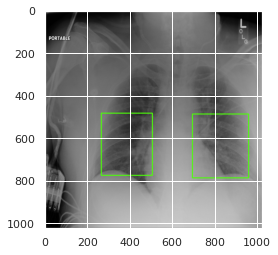

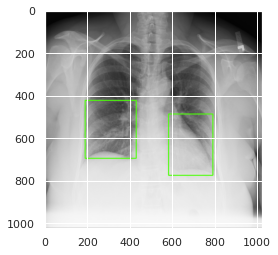

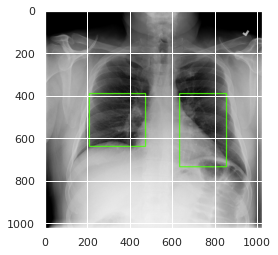

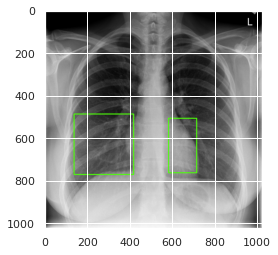

In [88]:
# show a few test image detection example
def visualize(): 
    image_id = random.choice(test_image_fps)
    ds = pydicom.read_file(image_id)
    
    # original image 
    image = ds.pixel_array
    
    # assume square image 
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    
    # If grayscale. Convert to RGB for consistency.
    if len(image.shape) != 3 or image.shape[2] != 3:
        image = np.stack((image,) * 3, -1) 
    resized_image, window, scale, padding, crop = utils.resize_image(
        image,
        min_dim=config.IMAGE_MIN_DIM,
        min_scale=config.IMAGE_MIN_SCALE,
        max_dim=config.IMAGE_MAX_DIM,
        mode=config.IMAGE_RESIZE_MODE)

    patient_id = os.path.splitext(os.path.basename(image_id))[0]
    print(patient_id)

    results = model.detect([resized_image])
    r = results[0]
    for bbox in r['rois']: 
        print(bbox)
        x1 = int(bbox[1] * resize_factor)
        y1 = int(bbox[0] * resize_factor)
        x2 = int(bbox[3] * resize_factor)
        y2 = int(bbox[2]  * resize_factor)
        cv2.rectangle(image, (x1,y1), (x2,y2), (77, 255, 9), 3, 1)
        width = x2 - x1 
        height = y2 - y1 
        print("x {} y {} h {} w {}".format(x1, y1, width, height))
    plt.figure() 
    plt.imshow(image, cmap=plt.cm.gist_gray)

visualize()
visualize()
visualize()
visualize()